In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/starbucks-capstone-challenge/transcript.csv
/kaggle/input/starbucks-capstone-challenge/profile.csv
/kaggle/input/starbucks-capstone-challenge/portfolio.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [3]:
transcript = pd.read_csv('/kaggle/input/starbucks-capstone-challenge/transcript.csv')
portfolio = pd.read_csv('/kaggle/input/starbucks-capstone-challenge/portfolio.csv')
profile = pd.read_csv('/kaggle/input/starbucks-capstone-challenge/profile.csv')

Offers received 25300
Offers viewed   13581 (53.7% of received)
Offers completed 4176 (16.5% of received)


/tmp/ipykernel_17/2892966715.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=events_to_plot, y=counts, palette="viridis")


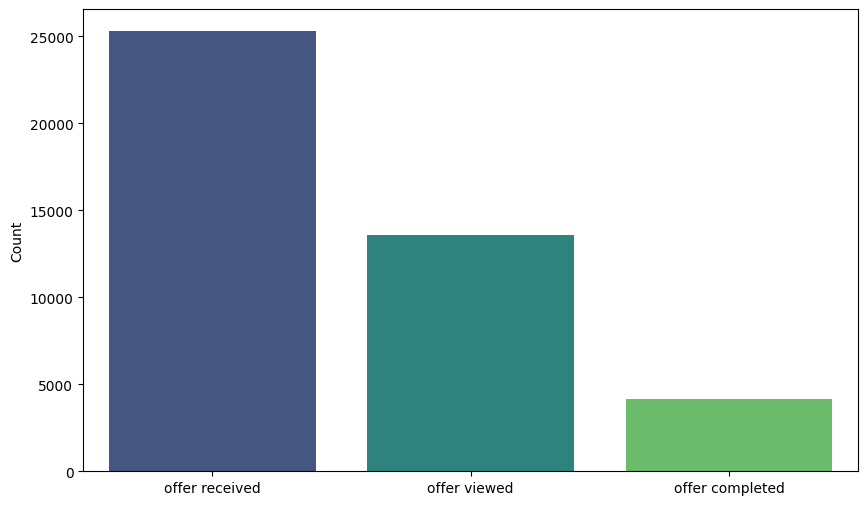

In [4]:
event_counts = transcript['event'].value_counts()
total_events = len(transcript)

n_received = event_counts.get('offer received', 0)
n_viewed = event_counts.get('offer viewed', 0)
n_completed = event_counts.get('offer completed', 0)

print(f"Offers received {n_received}")
print(f"Offers viewed   {n_viewed} ({n_viewed/n_received*100:.1f}% of received)")
print(f"Offers completed {n_completed} ({n_completed/n_received*100:.1f}% of received)")

#Visualization
events_to_plot = ['offer received', 'offer viewed', 'offer completed']
counts = [n_received, n_viewed, n_completed]

plt.figure(figsize=(10, 6))
sns.barplot(x=events_to_plot, y=counts, palette="viridis")
plt.ylabel("Count")
plt.show()

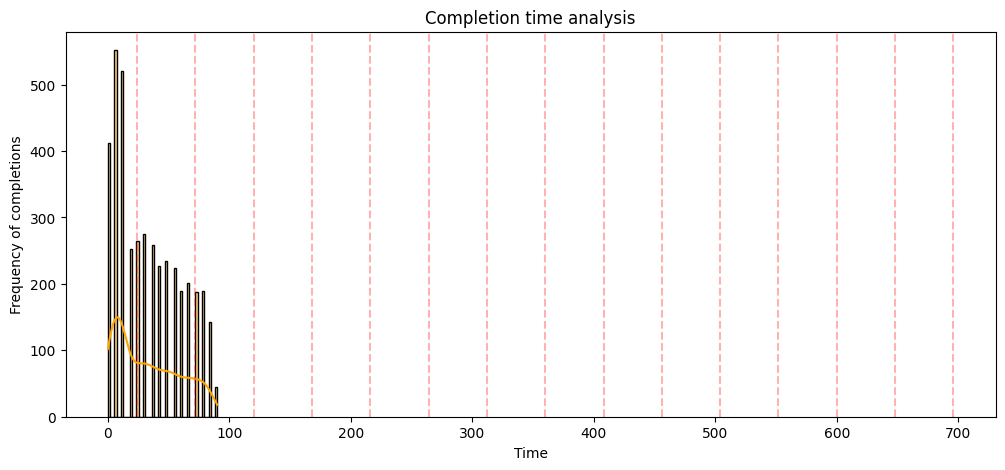

In [5]:
completed_data = transcript[transcript['event'] == 'offer completed']

plt.figure(figsize=(12, 5))
sns.histplot(completed_data['time'], bins=50, kde=True, color='orange')
plt.title("Completion time analysis")
plt.xlabel("Time")
plt.ylabel("Frequency of completions")

for day in range(1, 30, 2):
    plt.axvline(day * 24, color='red', linestyle='--', alpha=0.3)

plt.show()

Day 2:Cleaning

In [6]:
# profile cleaning
if 'id' in profile.columns:
    profile.rename(columns={'id': 'customer_id'}, inplace=True)

profile['age'] = profile['age'].replace(118, np.nan)
profile['income'] = profile['income'].fillna(profile['income'].median())
profile['gender'] = profile['gender'].fillna('O') # O for Unknown

if 'became_member_on' in profile.columns:
    profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

In [7]:
# portfolio cleaning
if 'id' in portfolio.columns:
    portfolio.rename(columns={'id': 'offer_id'}, inplace=True)

channel_cols = [c for c in portfolio.columns if 'channels' in c]

for ch in ['web', 'email', 'mobile', 'social']:
    portfolio[ch] = 0

for index, row in portfolio.iterrows():
    row_channels = str([row[c] for c in channel_cols])
    
    if 'web' in row_channels: portfolio.at[index, 'web'] = 1
    if 'email' in row_channels: portfolio.at[index, 'email'] = 1
    if 'mobile' in row_channels: portfolio.at[index, 'mobile'] = 1
    if 'social' in row_channels: portfolio.at[index, 'social'] = 1

portfolio.drop(columns=channel_cols, inplace=True)

In [8]:
# transcript cleaning
if 'person' in transcript.columns:
    transcript.rename(columns={'person': 'customer_id'}, inplace=True)

cols = transcript.columns
if 'value/offer id' in cols and 'value/offer_id' in cols:
    transcript['offer_id'] = transcript['value/offer id'].combine_first(transcript['value/offer_id'])
elif 'value/offer id' in cols:
    transcript['offer_id'] = transcript['value/offer id']
elif 'value/offer_id' in cols:
    transcript['offer_id'] = transcript['value/offer_id']

if 'value/amount' in cols:
    transcript.rename(columns={'value/amount': 'amount'}, inplace=True)

messy_cols = ['value/offer id', 'value/offer_id', 'value/reward', 'value']
transcript.drop(columns=[c for c in messy_cols if c in transcript.columns], inplace=True)

In [9]:
merged_df = pd.merge(transcript, profile, on='customer_id', how='left')
master_df = pd.merge(merged_df, portfolio, on='offer_id', how='left')

master_df.head(3)

,customer_id,event,time,amount,offer_id,gender,age,became_member_on,income,reward,difficulty,duration,offer_type,web,email,mobile,social
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75.0,2017-05-09,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,O,NaN,2017-08-04,64000.0,5.0,20.0,10.0,discount,1.0,1.0,0.0,0.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,M,68.0,2018-04-26,70000.0,2.0,10.0,7.0,discount,1.0,1.0,1.0,0.0


Day 3

In [10]:
transactions = master_df[master_df['event'] == 'transaction'].copy()

spending_df = transactions.groupby('customer_id').agg(
    total_amount=('amount', 'sum'),
    total_transactions=('amount', 'count')
).reset_index()

# Calculating average transaction value (ATV)
spending_df['avg_transaction_value'] = spending_df['total_amount'] / spending_df['total_transactions']

print(f"Processed spending for {len(spending_df)} customers")

Processed spending for 8476 customers


In [11]:
offer_events = master_df[master_df['event'].isin(['offer received', 'offer viewed', 'offer completed'])].copy()

engagement_df = offer_events.groupby(['customer_id', 'event']).size().unstack(fill_value=0).reset_index()

rename_map = {
    'offer received': 'total_received',
    'offer viewed': 'total_viewed',
    'offer completed': 'total_completed'
}
engagement_df.rename(columns=rename_map, inplace=True)

for col in ['total_received', 'total_viewed', 'total_completed']:
    if col not in engagement_df.columns:
        engagement_df[col] = 0

# Feature 1 View rate
engagement_df['view_rate'] = engagement_df['total_viewed'] / engagement_df['total_received']
engagement_df['view_rate'] = engagement_df['view_rate'].fillna(0)

# Feature 2 Completion rate
engagement_df['completion_rate'] = engagement_df['total_completed'] / engagement_df['total_received']
engagement_df['completion_rate'] = engagement_df['completion_rate'].fillna(0)

engagement_df['view_rate'] = engagement_df['view_rate'].clip(upper=1.0)
engagement_df['completion_rate'] = engagement_df['completion_rate'].clip(upper=1.0)

print(f"Processed engagement for {len(engagement_df)} customers.")

Processed engagement for 12650 customers.


In [12]:
base_profile = master_df[['customer_id', 'age', 'income', 'became_member_on']].drop_duplicates(subset='customer_id').copy()

max_date = pd.to_datetime('2018-07-31') 
base_profile['membership_days'] = (max_date - base_profile['became_member_on']).dt.days

# Merging spending
customer_df = pd.merge(base_profile, spending_df, on='customer_id', how='left')

# 4. Merging engagement
customer_df = pd.merge(customer_df, engagement_df, on='customer_id', how='left')

customer_df.fillna(0, inplace=True)

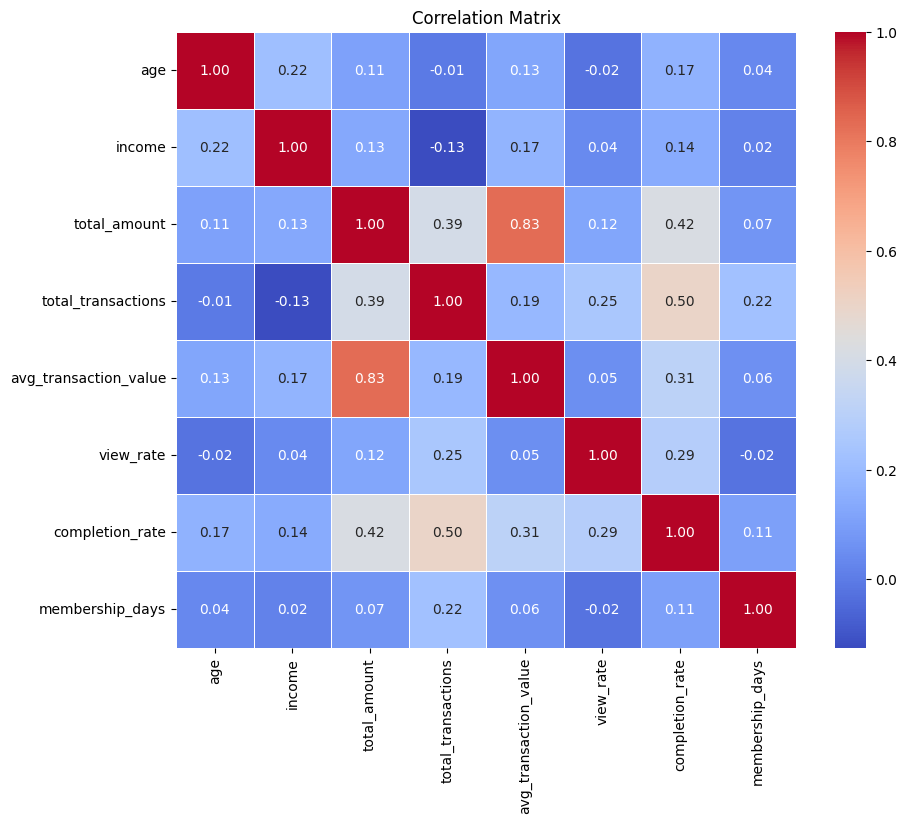

Correlation between income and total spend 0.13


In [13]:
cols_to_corr = ['age', 'income', 'total_amount', 'total_transactions', 
                'avg_transaction_value', 'view_rate', 'completion_rate', 'membership_days']

plt.figure(figsize=(10, 8))
corr = customer_df[cols_to_corr].corr()

sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

income_spend_corr = corr.loc['income', 'total_amount']
print(f"Correlation between income and total spend {income_spend_corr:.2f}")

Day 4

In [14]:
features = ['age', 'income', 'total_amount', 'total_transactions', 
            'avg_transaction_value', 'view_rate', 'completion_rate', 'membership_days']

X = customer_df[features].copy()

X.replace([np.inf, -np.inf], 0, inplace=True)
X.fillna(0, inplace=True)

In [15]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

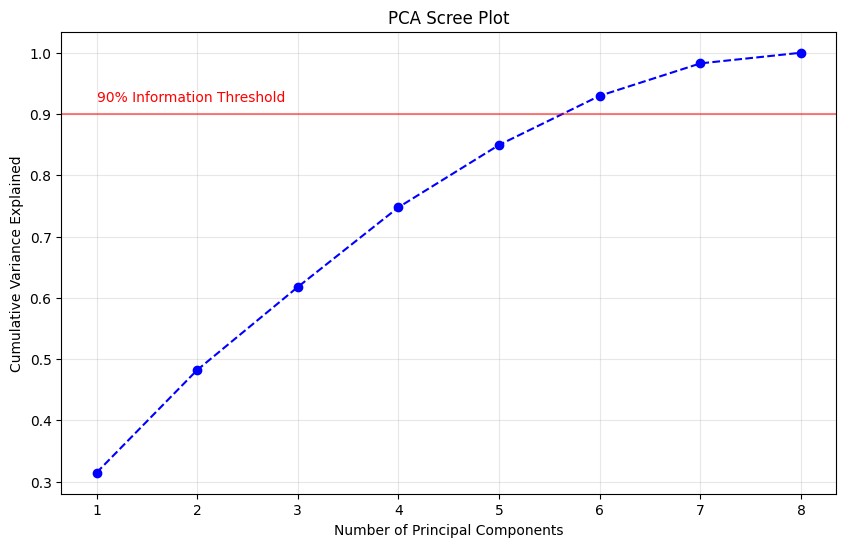

In [16]:
pca = PCA()
pca.fit(X_scaled)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='b')
plt.title('PCA Scree Plot')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')

plt.axhline(y=0.90, color='r', linestyle='-', alpha=0.5) 
plt.text(1, 0.92, '90% Information Threshold', color='red', fontsize=10)

plt.grid(True, alpha=0.3)
plt.show()

In [17]:
pca_final = PCA(n_components=3)
X_pca = pca_final.fit_transform(X_scaled)

print(f"Total Variance Retained: {sum(pca_final.explained_variance_ratio_)*100:.2f}%")

Total Variance Retained: 61.76%


Day 5

     K=2: Silhouette Score = 0.421
     K=3: Silhouette Score = 0.415
     K=4: Silhouette Score = 0.355
     K=5: Silhouette Score = 0.352
     K=6: Silhouette Score = 0.353
     K=7: Silhouette Score = 0.353
     K=8: Silhouette Score = 0.304
     K=9: Silhouette Score = 0.293
     K=10: Silhouette Score = 0.297


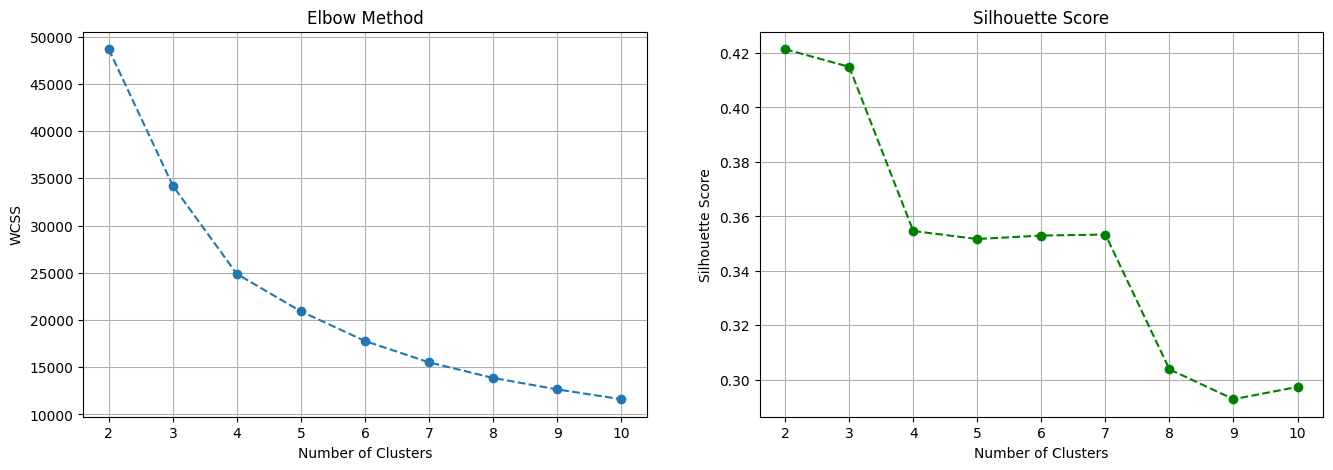

In [18]:
wcss = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)
    
    score = silhouette_score(X_pca, kmeans.labels_)
    silhouette_scores.append(score)
    print(f"     K={k}: Silhouette Score = {score:.3f}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

ax1.plot(range(2, 11), wcss, marker='o', linestyle='--')
ax1.set_title('Elbow Method')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('WCSS')
ax1.grid(True)

ax2.plot(range(2, 11), silhouette_scores, marker='o', color='green', linestyle='--')
ax2.set_title('Silhouette Score')
ax2.set_xlabel('Number of Clusters')
ax2.set_ylabel('Silhouette Score')
ax2.grid(True)

plt.show()

In [19]:
best_k = 4

kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
clusters = kmeans_final.fit_predict(X_pca)

customer_df['Cluster'] = clusters

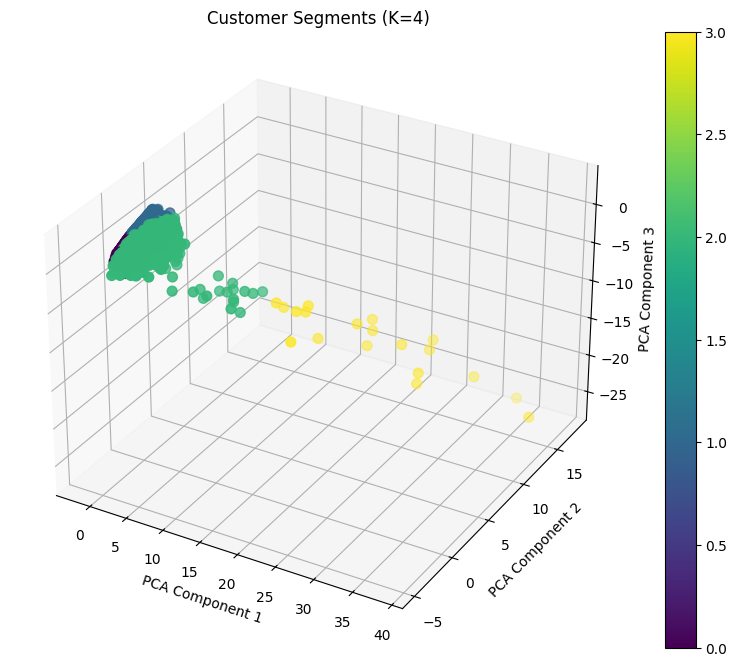

Cluster
0    6356
1    4521
2    3277
3      19
Name: count, dtype: int64


In [20]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=clusters, cmap='viridis', s=50)

ax.set_title(f'Customer Segments (K={best_k})')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
plt.colorbar(scatter)
plt.show()
print(customer_df['Cluster'].value_counts())

Day 6

In [21]:
dbscan = DBSCAN(eps=0.5, min_samples=20)
dbscan_labels = dbscan.fit_predict(X_pca)

n_clusters_db = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise_db = list(dbscan_labels).count(-1)

print(f"     -> Found {n_clusters_db} Clusters and {n_noise_db} Noise points (Outliers).")

     -> Found 1 Clusters and 315 Noise points (Outliers).


In [22]:
def print_metrics(model_name, data, labels):
    sil = silhouette_score(data, labels)
    
    ch = calinski_harabasz_score(data, labels)
    
    db = davies_bouldin_score(data, labels)
    
    print(f"{model_name} Results:")
    print(f"Silhouette Score:       {sil:.4f}")
    print(f"Calinski-Harabasz Idx:  {ch:.1f}")
    print(f"Davies-Bouldin Index:   {db:.4f}")
    return sil, ch, db

print_metrics("K-Means", X_pca, clusters)

print_metrics("DBSCAN", X_pca, dbscan_labels)

K-Means Results:
Silhouette Score:       0.3547
Calinski-Harabasz Idx:  8572.7
Davies-Bouldin Index:   0.8199
DBSCAN Results:
Silhouette Score:       0.6201
Calinski-Harabasz Idx:  1812.1
Davies-Bouldin Index:   1.2446


(np.float64(0.6201047085965762),
 np.float64(1812.0635385409028),
 np.float64(1.2446361689617118))

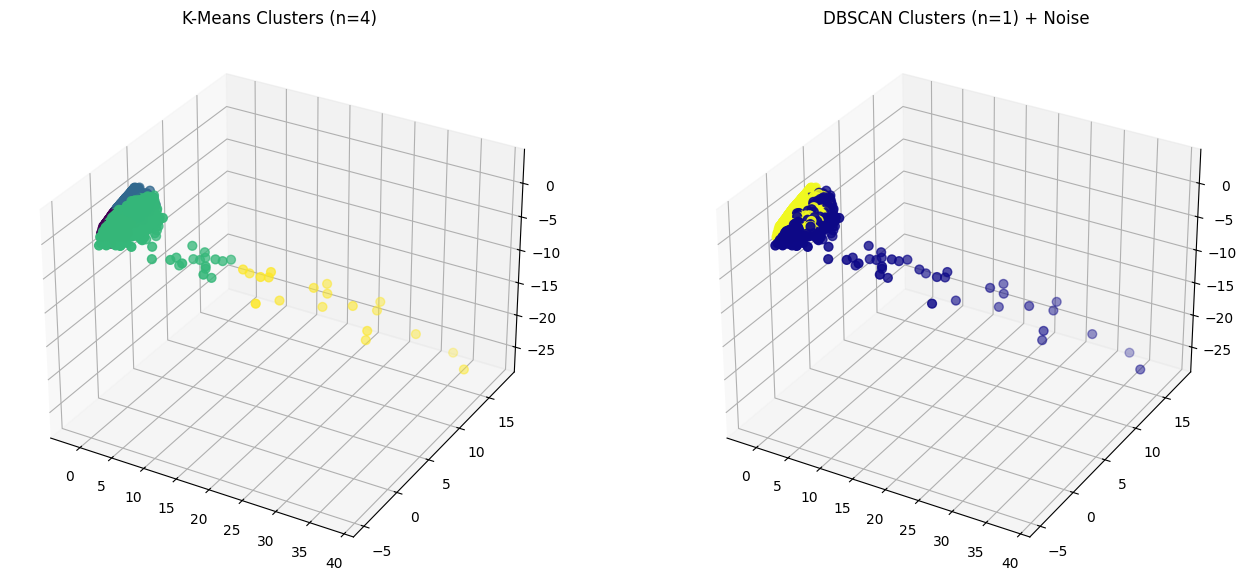

In [23]:
fig = plt.figure(figsize=(16, 7))

# Plotting K-Means
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=clusters, cmap='viridis', s=40)
ax1.set_title(f'K-Means Clusters (n={len(set(clusters))})')

# Plotting DBSCAN
ax2 = fig.add_subplot(122, projection='3d')
scatter = ax2.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=dbscan_labels, cmap='plasma', s=40)
ax2.set_title(f'DBSCAN Clusters (n={n_clusters_db}) + Noise')

plt.show()

Day 7

In [24]:
cluster_summary = customer_df.groupby('Cluster')[['age', 'income', 'total_amount', 'total_transactions', 'view_rate', 'completion_rate']].mean()

cluster_summary['count'] = customer_df['Cluster'].value_counts()

print("Cluster Profiles (Averages):")
cluster_summary.round(2)

Cluster Profiles (Averages):


,age,income,total_amount,total_transactions,view_rate,completion_rate,count
Cluster,,,,,,,
0,31.19,52553.81,4.55,0.92,0.39,0.02,6356
1,64.25,80123.20,7.27,0.41,0.39,0.05,4521
2,55.06,67843.15,41.90,2.80,0.78,0.53,3277
3,54.47,84947.37,851.28,2.32,0.68,0.63,19


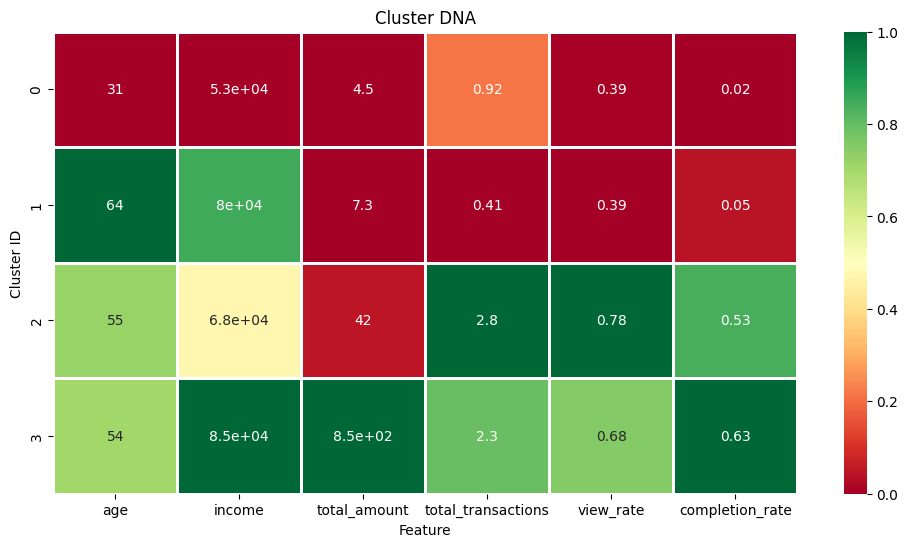

In [25]:
plt.figure(figsize=(12, 6))

normalized_summary = cluster_summary.drop(columns=['count']).apply(lambda x: (x - x.min()) / (x.max() - x.min()))

sns.heatmap(normalized_summary, annot=cluster_summary.drop(columns=['count']).round(2), cmap='RdYlGn', linewidths=1)
plt.title('Cluster DNA')
plt.xlabel('Feature')
plt.ylabel('Cluster ID')
plt.show()

In [26]:
for i, row in cluster_summary.iterrows():
    name = "Standard Customer"
    strategy = "Maintain Engagement"
    
    if row['total_amount'] > 150:
        name = "The Whales (High Spenders)"
        strategy = "Premium Rewards & Exclusive Access"
    elif row['completion_rate'] > 0.7:
        name = "The BOGO Hunters"
        strategy = "Send Discount Offers (They respond!)"
    elif row['view_rate'] < 0.2 and row['total_amount'] < 20:
        name = "The Ghosts (Inactive)"
        strategy = "Re-engagement Campaign or Ignore"
    elif row['total_transactions'] > 10 and row['total_amount'] < 100:
        name = "The Morning Coffee Regulars"
        strategy = "Loyalty Cards (Volume based)"
        
    print(f"   Cluster {i}: {name}")
    print(f"      -> Strategy: {strategy}")

   Cluster 0: Standard Customer
      -> Strategy: Maintain Engagement
   Cluster 1: Standard Customer
      -> Strategy: Maintain Engagement
   Cluster 2: Standard Customer
      -> Strategy: Maintain Engagement
   Cluster 3: The Whales (High Spenders)
      -> Strategy: Premium Rewards & Exclusive Access
